In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# Extracting Data from the Home_consumption_dataset to Dataframe
pow_df = pd.read_csv("powerconsumption.csv")
# pow_df['Datetime']=pd.to_datetime(pow_df.Datetime)
pow_df['Datetime'] = pd.to_datetime(pow_df['Datetime'])
#pow_df.set_index('Datetime', inplace=True)
pow_df.head()

,Datetime,Temperature,Humidity,WindSpeed,Power_Consumption
0,2017-01-01 00:00:00,6.559,73.8,0.083,70425.53544
1,2017-01-01 00:10:00,6.414,74.5,0.083,69320.84387
2,2017-01-01 00:20:00,6.313,74.5,0.080,67803.22193
3,2017-01-01 00:30:00,6.121,75.0,0.083,65489.23209
4,2017-01-01 00:40:00,5.921,75.7,0.081,63650.44627


In [3]:
#Data aggregation by Datetime and perform data calculations
grouped_data = pow_df.groupby(pd.Grouper(key='Datetime', freq='D'))
result = grouped_data[['Temperature', 'Humidity', 'WindSpeed', 'Power_Consumption']].sum()
result['Temperature'] = grouped_data['Temperature'].median().round(3)
result['Humidity'] = grouped_data['Humidity'].mean().round(3)
result['WindSpeed'] = grouped_data['WindSpeed'].mean().round(3)
result['Power_Consumption(MWh)'] = (result['Power_Consumption'] / 1000).round(3)

result.reset_index(inplace=True)
#rename the columns
result.rename(columns={'Power_Consumption': 'kWh_consumption', 
                   'Power_Consumption(MWh)': 'MWh_consumption'}, inplace=True)
result.head()

,Datetime,Temperature,Humidity,WindSpeed,kWh_consumption,MWh_consumption
0,2017-01-01,11.305,68.519,0.315,9.226342e+06,9226.342
1,2017-01-02,12.875,71.456,0.077,9.539709e+06,9539.709
2,2017-01-03,11.820,74.982,0.077,9.826635e+06,9826.635
3,2017-01-04,9.640,75.460,0.082,9.859047e+06,9859.047
4,2017-01-05,9.905,71.040,0.084,9.864148e+06,9864.148


In [4]:
# Separate Target Variable and Predictor Variables
TargetVariable=['MWh_consumption']
Predictors=['Temperature', 'Humidity', 'WindSpeed']

X=result[Predictors].values
y=result[TargetVariable].values

### Sandardization of data
from sklearn.preprocessing import StandardScaler
PredictorScaler=StandardScaler()
TargetVarScaler=StandardScaler()

# Storing the fit object for later reference
PredictorScalerFit=PredictorScaler.fit(X)
TargetVarScalerFit=TargetVarScaler.fit(y)

# Generating the standardized values of X and y
X=PredictorScalerFit.transform(X)
y=TargetVarScalerFit.transform(y)

# Split the data into training (75%) and testing (25%) set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Quick sanity check with the shapes of Training and testing datasets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(273, 3)
(273, 1)
(91, 3)
(91, 1)


In [5]:
# importing the libraries
from keras.models import Sequential
from keras.layers import Dense

# create ANN model
model = Sequential()

# Defining the Input layer and FIRST hidden layer, both are same!
model.add(Dense(units=3, input_dim=3, kernel_initializer='normal', activation='relu'))

# Defining the Second layer of the model
# after the first layer we don't have to specify input_dim as keras configure it automatically
model.add(Dense(units=9, kernel_initializer='normal', activation='tanh'))

model.add(Dense(units=18, kernel_initializer='normal', activation='tanh'))

model.add(Dense(units=9, kernel_initializer='normal', activation='tanh'))

# The output neuron is a single fully connected node 
# Since we will be predicting a single number
model.add(Dense(1, kernel_initializer='normal'))

# Compiling the model
# model.compile(loss='mean_squared_error', optimizer='adam')
model.compile(optimizer = 'adam', loss = 'mean_squared_error',metrics=['MeanSquaredLogarithmicError'])

model.summary()

c:\Users\samyo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 3)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 18)             │           180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │           171 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            10 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 409 (1.60 KB)

 Trainable params: 409 (1.60 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Training the ANN based on the Training set
model_hist = model.fit(X_train, y_train ,batch_size = 3, epochs = 100, verbose=1, validation_data=(X_test, y_test),
              shuffle=True)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - MeanSquaredLogarithmicError: 0.2077 - loss: 0.9493 - val_MeanSquaredLogarithmicError: 0.1923 - val_loss: 0.9646
Epoch 2/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - MeanSquaredLogarithmicError: 0.2002 - loss: 1.0087 - val_MeanSquaredLogarithmicError: 0.0642 - val_loss: 0.4385
Epoch 3/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - MeanSquaredLogarithmicError: 0.0745 - loss: 0.5047 - val_MeanSquaredLogarithmicError: 0.0486 - val_loss: 0.3558
Epoch 4/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - MeanSquaredLogarithmicError: 0.0688 - loss: 0.4613 - val_MeanSquaredLogarithmicError: 0.0417 - val_loss: 0.3124
Epoch 5/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - MeanSquaredLogarithmicError: 0.0639 - loss: 0.4607 - val_MeanSquaredLogarithmicError: 0.0408 - val_loss: 0.3023
Epoch 6/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - MeanSquaredLogarithmicError: 0.0546 - loss: 0.3728 - val_MeanSquaredLogarithmicError: 0.0370 - val_loss: 0.2752
Epoch 7/10

In [ ]:
#Predicting values based on x_test
y_pred = model.predict(X_test)
np.set_printoptions(precision=2)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[ 1.5   2.17]
 [-0.57 -0.58]
 [-0.59 -0.41]
 [-0.58 -0.75]
 [-0.54 -0.45]
 [ 0.88  1.14]
 [-0.59 -0.64]
 [-0.04 -0.89]
 [ 0.02  0.36]
 [-0.22 -0.83]
 [ 0.45  2.18]
 [-0.59 -0.56]
 [-0.28 -0.48]
 [-0.58 -0.62]
 [-0.27  0.01]
 [-0.18 -0.39]
 [-0.6  -0.86]
 [ 0.15  1.81]
 [-0.49 -0.91]
 [-0.5  -0.39]
 [-0.55 -0.3 ]
 [-0.01  0.73]
 [-0.55 -0.43]
 [-0.6  -0.8 ]
 [ 0.29 -0.34]
 [ 2.    2.13]
 [ 2.03  2.75]
 [ 2.34  2.48]
 [-0.59 -0.75]
 [-0.55 -0.57]
 [-0.61 -0.05]
 [-0.51 -0.24]
 [-0.59 -0.75]
 [-0.59 -0.81]
 [ 1.99  1.82]
 [-0.46 -0.32]
 [-0.59 -1.01]
 [-0.6  -0.11]
 [-0.6  -0.81]
 [-0.51 -0.75]
 [-0.3  -0.4 ]
 [ 0.41 -0.25]
 [-0.54 -0.32]
 [ 0.24 -0.23]
 [-0.49 -0.27]
 [ 0.25  1.66]
 [-0.49 -0.61]
 [-0.57 -0.83]
 [-0.59 -0.35]
 [-0.54 -0.34]
 [ 0.46  2.17]
 [ 0.33 -0.3 ]
 [-0.11 -0.34]
 [-0.61 -0.63]
 [ 0.31  0.09]
 [-0.57 -1.45]
 [-0.52 -0.36]
 [-0.61 -0.33]
 [-0.61 -0.66]
 [-0.59 -0.99]
 [-0.21 -0.28]
 [ 0.11  0.22]
 [-0.58 -0.53]
 [-0.57 -0.26]
 [

In [ ]:
# Computing the absolute percent error
APE=100*(abs((y_test + 10) - (y_pred + 10))/(y_test + 10))
# TestingData['APE']=APE
 
print('The Accuracy of DNN model is:', 100-np.mean(APE))

The Accuracy of DNN model is: 96.73550301078635


In [ ]:
#Calculating metrics
import sklearn.metrics
ann = model
evs_no=sklearn.metrics.explained_variance_score(y_test,ann.predict(X_test))
me_no=sklearn.metrics.max_error(y_test,ann.predict(X_test))
mae_no=sklearn.metrics.mean_absolute_error(y_test,ann.predict(X_test))
mse_no=sklearn.metrics.mean_squared_error(y_test,ann.predict(X_test))
Mae_no=sklearn.metrics.median_absolute_error(y_test,ann.predict(X_test))
r2_no=sklearn.metrics.r2_score(y_test,ann.predict(X_test))
mtd_no=sklearn.metrics.mean_tweedie_deviance(y_test,ann.predict(X_test))
print('Explained Variance Score:',evs_no)
print('Max Error               :',me_no)
print('Mean Absolute Error     :',mae_no)
print('Mean Square Error       :',mse_no)
print('Median Absolute Error   :',Mae_no)
print('R2 Score                :',r2_no)
print('Mean Tweedie Deviance   :',mtd_no)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
Explained Variance Score: 0.7536190132636646
Max Error               : 1.732380578643907
Mean Absolute Error     : 0.3335619154047221
Mean Square Error       : 0.24013463113357295
Median Absolute Error   : 0.2135017324002463
R2 Score                : 0.7515857866303134
Mean Tweedie Deviance   : 0.24013463113357295


dict_keys(['MeanSquaredLogarithmicError', 'loss', 'val_MeanSquaredLogarithmicError', 'val_loss'])


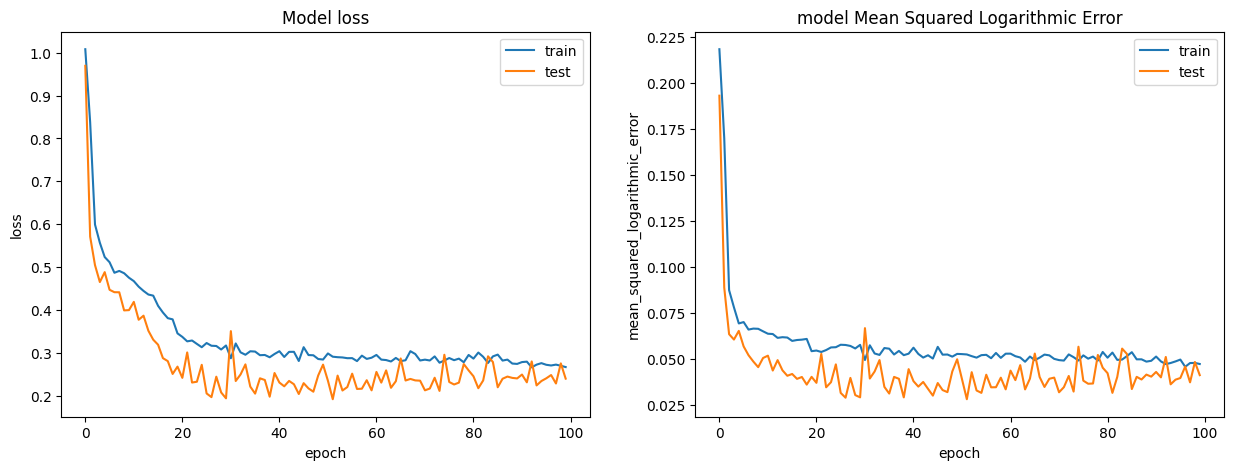

In [ ]:
# list all data in history
print(model_hist.history.keys())

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(model_hist.history['loss'])
plt.plot(model_hist.history['val_loss'])
# plt.grid()
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
# plt.show()

plt.subplot(1,2,2)
# summarize history for loss
plt.plot(model_hist.history['MeanSquaredLogarithmicError'])
plt.plot(model_hist.history['val_MeanSquaredLogarithmicError'])
# plot the loss graphs
plt.title('model Mean Squared Logarithmic Error')
plt.ylabel('mean_squared_logarithmic_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()